In [1]:
from stableVersion import _estimator, create_strategy_config, strategy_real_time_optimize

In [2]:
import threading
import sys
import pandas as pd
import platform
import numpy as np
from sklearn.model_selection import ParameterGrid
global RecursionBorder

if platform.platform().split('-')[0] == 'macOS':
    systemDivide = '/'
else:
    systemDivide = '\\'

threading.stack_size(2**27)
sys.setrecursionlimit(10 ** 5)

pairName = 'CHFJPY.csv'

inpData = pd.read_csv(f"..{systemDivide}testData{systemDivide}{pairName}", index_col=1)
# Какие колонки нужны для работы
columns = ['open', 'high', 'low', 'close']
inpData = inpData[columns]
inpData.index = pd.to_datetime(inpData.index)
# inpData = inpData.loc['2021-01-01':]
inpData

,open,high,low,close
time,,,,
2018-11-01 00:15:00,111.975,111.998,111.975,111.997
2018-11-01 00:16:00,111.997,112.000,111.995,111.996
2018-11-01 00:17:00,111.996,112.011,111.995,112.003
2018-11-01 00:18:00,112.003,112.004,111.981,111.982
2018-11-01 00:19:00,111.982,111.989,111.962,111.965
...,...,...,...,...
2021-11-13 00:55:00,123.669,123.672,123.660,123.665
2021-11-13 00:56:00,123.665,123.670,123.661,123.670
2021-11-13 00:57:00,123.670,123.673,123.657,123.660


In [3]:
RecursionBorder = 1000
grid_params = {
    # Оптимизировать !!!
    'yThreshold': [300],
    # Оптимизировать !
    'varianceRatioFilter': [1.0],
    'reverseVarianceRatioFilter': [1.0],
    # Оптимизировать !!
    'restAfterLoss': [200],
    # Оптимизировать !
    'restAfterFatProfit' : [1],
    # Оптимизировать !!
    'stopLossStdMultiplier': [80_00],
    # Оптимизировать !
    'takeProfitStdMultiplier': [4050],
    # Оптимизировать !!
    'varianceRatioCarreteParameter': [20],
    # Оптимизировать !!!
    'scanHalfTime': [2000],
    # Оптимизировать 0!
    'halfToFat': [2],
    # Оптимизировать 0!
    'halfToLight': [1],
    # Оптимизировать 0!
    'halfToTime': [2],
    }

grid_params = ParameterGrid(grid_params)
grid_params = pd.DataFrame(grid_params).sample(frac=1, random_state=9).reset_index(drop=True)

OPTIMIZATION:0:10080
0 of 14
1 of 14
2 of 14
3 of 14
4 of 14
5 of 14
6 of 14
7 of 14
8 of 14
9 of 14
10 of 14
11 of 14
12 of 14
13 of 14
14 of 14
TRADE:10080:30240
Position after trade period: 20702
OPTIMIZATION:10622:20702
0 of 14
ValueError 585
5836    15.082675
5837    15.082675
5838    15.082675
5839    15.082675
5840    15.082675
          ...    
6524    16.154781
6525    16.154781
6526    16.154781
6527    16.154781
6528    25.770184
Name: profit, Length: 693, dtype: float64
1 of 14
2 of 14
3 of 14
4 of 14
5 of 14
ValueError 585
5836    15.791502
5837    15.791502
5838    15.791502
5839    15.791502
5840    15.791502
          ...    
6519    15.791502
6520    15.791502
6521    15.791502
6522    15.791502
6523    24.782301
Name: profit, Length: 688, dtype: float64
6 of 14
7 of 14
8 of 14
9 of 14
ValueError 585
3737    -7.374025
3738    -7.374025
3739    -7.374025
3740    -7.374025
3741    -7.374025
          ...    
6519     1.102674
6520     1.102674
6521     1.102674
6522     

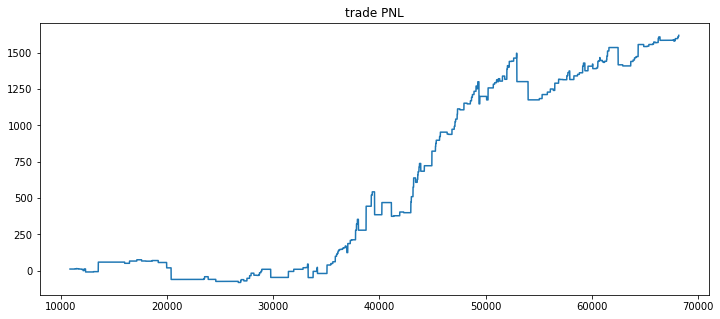

In [4]:
totalResult, RealTimeOptimizeTrades, paramsEvolution = strategy_real_time_optimize(realTimeData=inpData.iloc[450_000:890_000].copy(), parameters=create_strategy_config(grid_params.iloc[0]), show=True,
                                                                                   savePath='', update=False)

In [8]:
inpData.iloc[450_000:450_000+70_000]

,open,high,low,close
time,,,,
2020-01-29 15:58:00,111.906,111.907,111.901,111.902
2020-01-29 15:59:00,111.902,111.907,111.897,111.905
2020-01-29 16:00:00,111.905,111.920,111.898,111.920
2020-01-29 16:01:00,111.920,111.925,111.901,111.905
2020-01-29 16:02:00,111.905,111.913,111.904,111.911
...,...,...,...,...
2020-04-08 15:17:00,112.115,112.126,112.114,112.126
2020-04-08 15:18:00,112.126,112.132,112.121,112.131
2020-04-08 15:19:00,112.131,112.137,112.126,112.132


In [5]:
slippage = 2
trades = RealTimeOptimizeTrades[0]
for i in range(1, len(RealTimeOptimizeTrades)):
    trades = trades.append(RealTimeOptimizeTrades[i], ignore_index=True)
trades['profit'] = (trades["position"] * (trades["closePrice"] -
                                    trades["openPrice"]) - slippage
                 if (trades["typeOperation"] == 'BUY').bool
                 else abs(trades["position"]) * (trades["openPrice"] -
                                              trades["closePrice"]) - slippage)
trades['own_time'] = trades['closeIndex'] - trades['openIndex']
trades.groupby(by='typeHolding').describe().profit

,count,mean,std,min,25%,50%,75%,max
typeHolding,,,,,,,,
endPeriod,20.0,-45.229498,78.681158,-195.522958,-93.546548,-54.682701,25.801718,65.602354
fatExtraProfit,4.0,20.360954,18.316880,4.584767,8.125890,15.673171,27.908234,45.512704
lightCross,144.0,8.649494,23.008473,-52.961498,-1.887471,6.700123,19.855984,165.009285
lightCrossEmergent,49.0,26.881665,25.115166,-2.205809,8.821276,21.101453,37.405345,100.338789
stopLoss,1.0,-119.040640,NaN,-119.040640,-119.040640,-119.040640,-119.040640,-119.040640


In [6]:
import matplotlib.pyplot as plt
trades


,typeOperation,position,openPrice,openIndex,stopLossBorder,takeProfitBorder,typeHolding,closePrice,closeIndex,profit,own_time
0,BUY,178.180,112.246,10860,110.011,113.458,lightCross,112.317899,10916,10.810893,56
1,BUY,178.198,112.235,11328,111.422,112.692,lightCross,112.255727,11356,1.693559,28
2,BUY,178.156,112.261,11455,111.605,112.603,lightCrossEmergent,112.280886,11468,1.542759,13
3,SELL,-178.083,112.307,11531,112.794,112.089,lightCross,112.304968,11546,-1.638089,15
4,SELL,-178.040,112.334,11561,112.941,112.041,lightCross,112.321148,11570,0.288144,9
...,...,...,...,...,...,...,...,...,...,...,...
213,SELL,-179.195,111.610,67808,112.817,110.836,lightCrossEmergent,111.557889,67823,7.338051,15
214,BUY,179.515,111.411,67850,109.273,113.131,lightCross,111.477429,67885,9.924925,35
215,SELL,-179.422,111.469,68082,112.725,110.636,lightCross,111.402826,68084,9.873056,2
216,SELL,-179.417,111.472,68130,112.963,110.570,lightCross,111.428086,68161,5.878969,31


In [9]:
trades.own_time.mean()

82.10091743119266

In [7]:

# totalResult, RealTimeOptimizeTrades, paramsEvolution = strategy_real_time_optimize(realTimeData=inpData.iloc[0:400_000].copy(), parameters=create_strategy_config(grid_params.iloc[0]), show=True,
                                                                                   savePath='', update=False)

IndentationError: unexpected indent (1130132792.py, line 2)

In [ ]:
slippage = 2
trades = RealTimeOptimizeTrades[0]
for i in range(1, len(RealTimeOptimizeTrades)):
    trades = trades.append(RealTimeOptimizeTrades[i], ignore_index=True)
trades['profit'] = (trades["position"] * (trades["closePrice"] -
                                    trades["openPrice"]) - slippage
                 if (trades["typeOperation"] == 'BUY').bool
                 else abs(trades["position"]) * (trades["openPrice"] -
                                              trades["closePrice"]) - slippage)
trades['own_time'] = trades['closeIndex'] - trades['openIndex']

In [ ]:
trades.groupby(by='typeHolding').describe().profit

In [ ]:
trades[trades.typeHolding == 'stopLoss']

In [ ]:
import matplotlib.pylab as plt

plt.figure(figsize=(12,7))
plt.style.use('Solarize_Light2')
plt.title('MarkOut')
plt.hlines(y=0, xmin=0, xmax=max(trades['own_time']), colors='red')
plt.plot(trades.groupby(by='own_time').profit.mean() / 20_000, '--')
plt.show()

In [ ]:
plt.plot(inpData.iloc[:400_000].copy().open)

In [ ]:
_estimator(_DATAFRAME=inpData.iloc[20_000:30_000].copy(),
           _gridParams=create_strategy_config(grid_params.iloc[0]),
           show=True)

In [ ]:
totalResult, RealTimeOptimizeTrades, paramsEvolution = strategy_real_time_optimize(realTimeData=inpData.iloc[:400_000].copy(), parameters=create_strategy_config(grid_params.iloc[0]), show=True)